In [24]:
# NEW CELL 1: Extraction with Global Normalization Option
from scipy import stats as scipy_stats
import numpy as np
import nibabel as nib

def extract_contrast_values_v2(subject_id, roi_type, use_anatomical_only=False, 
                                global_normalize=False):
    """
    Extract face-word or object-house contrast from ROI
    
    Parameters:
    -----------
    global_normalize : bool
        If True, z-score each session's whole brain before ROI extraction
        Removes session-wide signal differences
    """
    hemi = SUBJECTS[subject_id]['hemi']
    
    if use_anatomical_only:
        # Liu's approach - full anatomical mask
        if roi_type == 'face_word':
            roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_fusiform_mask_dilated.nii.gz'
        else:
            roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_LO_PPA_mask_dilated.nii.gz'
        roi_label = "Anatomical"
    else:
        # Your approach - functionally restricted
        roi_file = BASE_DIR / subject_id / 'ses-01' / 'ROIs' / f'{hemi}_{roi_type}_dual_cluster.nii.gz'
        roi_label = "Functional"
    
    roi_mask = nib.load(roi_file).get_fdata() > 0
    voxel_indices = np.where(roi_mask)
    n_voxels = np.sum(roi_mask)
    
    contrast_cope = 13 if roi_type == 'face_word' else 14
    
    session_data = {}
    global_stats = {}  # Renamed to avoid collision
    
    for session in SUBJECTS[subject_id]['sessions']:
        # Use ses01-registered version for all sessions except ses-01
        if session == '01':
            zstat_filename = 'zstat1.nii.gz'
        else:
            zstat_filename = 'zstat1_ses01.nii.gz'
        
        zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                     'HighLevel.gfeat' / f'cope{contrast_cope}.feat' / 'stats' / zstat_filename
        
        if zstat_file.exists():
            zstat_img = nib.load(zstat_file)
            zstat_data = zstat_img.get_fdata()
            
            if global_normalize:
                # Global normalization: z-score entire brain
                brain_mask = zstat_data != 0  # non-zero voxels only
                global_mean = zstat_data[brain_mask].mean()
                global_std = zstat_data[brain_mask].std()
                
                zstat_normalized = (zstat_data - global_mean) / global_std
                
                # Store normalization info for diagnostics
                global_stats[session] = {
                    'global_mean': global_mean,
                    'global_std': global_std,
                    'n_brain_voxels': brain_mask.sum()
                }
                
                session_data[session] = zstat_normalized[voxel_indices]
            else:
                # Original approach: raw z-stats
                session_data[session] = zstat_data[voxel_indices]
        else:
            print(f"  ⚠️  Warning: {zstat_filename} not found for {subject_id} ses-{session}")
    
    return session_data, n_voxels, roi_label, global_stats

def compare_sessions_v2(subject_id, roi_type='face_word', global_normalize=False):
    """Compare both ROI approaches with optional global normalization"""
    code = SUBJECTS[subject_id]['code']
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    norm_label = " (Globally Normalized)" if global_normalize else " (Raw Z-stats)"
    
    print(f"\n{'='*80}")
    print(f"{code} - {roi_name}{norm_label}")
    print(f"{'='*80}")
    
    for use_anat in [False, True]:
        session_data, n_voxels, roi_label, global_stats = extract_contrast_values_v2(
            subject_id, roi_type, use_anatomical_only=use_anat, 
            global_normalize=global_normalize
        )
        
        sessions = sorted(session_data.keys())
        
        print(f"\n{roi_label} ROI ({n_voxels} voxels)")
        print("-"*80)
        
        # Show global normalization stats if applicable
        if global_normalize and global_stats:
            print("\nGlobal normalization stats:")
            for ses in sessions:
                if ses in global_stats:
                    stat_info = global_stats[ses]
                    print(f"  ses-{ses}: mean={stat_info['global_mean']:.2f}, std={stat_info['global_std']:.2f}")
        
        # Pairwise comparisons
        for i in range(len(sessions)):
            for j in range(i+1, len(sessions)):
                ses1, ses2 = sessions[i], sessions[j]
                
                n1 = len(session_data[ses1])
                n2 = len(session_data[ses2])
                df = n1 + n2 - 2
                
                t_stat, p_val = scipy_stats.ttest_ind(session_data[ses1], session_data[ses2])
                
                mean1 = session_data[ses1].mean()
                mean2 = session_data[ses2].mean()
                std1 = session_data[ses1].std()
                std2 = session_data[ses2].std()
                diff = mean2 - mean1
                
                sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                
                comparison = f"ses-{ses1} vs ses-{ses2}"
                
                print(f"\n  {comparison}:")
                print(f"    n1={n1}, n2={n2}, df={df}")
                print(f"    Mean: {mean1:.2f} (SD={std1:.2f}) → {mean2:.2f} (SD={std2:.2f}), Δ={diff:+.2f}")
                print(f"    t={t_stat:.3f}, p={p_val:.4f} {sig}")

In [25]:
# NEW CELL 2: Run comparison WITH and WITHOUT global normalization
print("="*80)
print("COMPARISON: RAW Z-STATS (Original Approach)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        compare_sessions_v2(subject_id, roi_type, global_normalize=False)

print("\n\n")
print("="*80)
print("COMPARISON: GLOBALLY NORMALIZED (Correcting for Session-Wide Signal)")
print("="*80)

for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        compare_sessions_v2(subject_id, roi_type, global_normalize=True)

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

COMPARISON: RAW Z-STATS (Original Approach)

UD - Face-Word (Raw Z-stats)



Functional ROI (8023 voxels)
--------------------------------------------------------------------------------

  ses-01 vs ses-02:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 0.44 (SD=1.53), Δ=-1.18
    t=49.526, p=0.0000 ***

  ses-01 vs ses-03:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 0.63 (SD=1.19), Δ=-0.99
    t=46.394, p=0.0000 ***

  ses-01 vs ses-05:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 1.40 (SD=1.58), Δ=-0.23
    t=9.364, p=0.0000 ***

  ses-01 vs ses-06:
    n1=8023, n2=8023, df=16044
    Mean: 1.62 (SD=1.49) → 1.87 (SD=1.24), Δ=+0.25
    t=-11.379, p=0.0000 ***

  ses-02 vs ses-03:
    n1=8023, n2=8023, df=16044
    Mean: 0.44 (SD=1.53) → 0.63 (SD=1.19), Δ=+0.19
    t=-8.953, p=0.0000 ***

  ses-02 vs ses-05:
    n1=8023, n2=8023, df=16044
    Mean: 0.44 (SD=1.53) → 1.40 (SD=1.58), Δ=+0.96
    t=-38.967, p=0.0000 ***

  ses-02 vs ses-06:
    n1=8023, n2=8023, df=16044
    Mean: 0.44 (SD=1.53) → 1.87 (SD=1.24), Δ=+1.43
    t

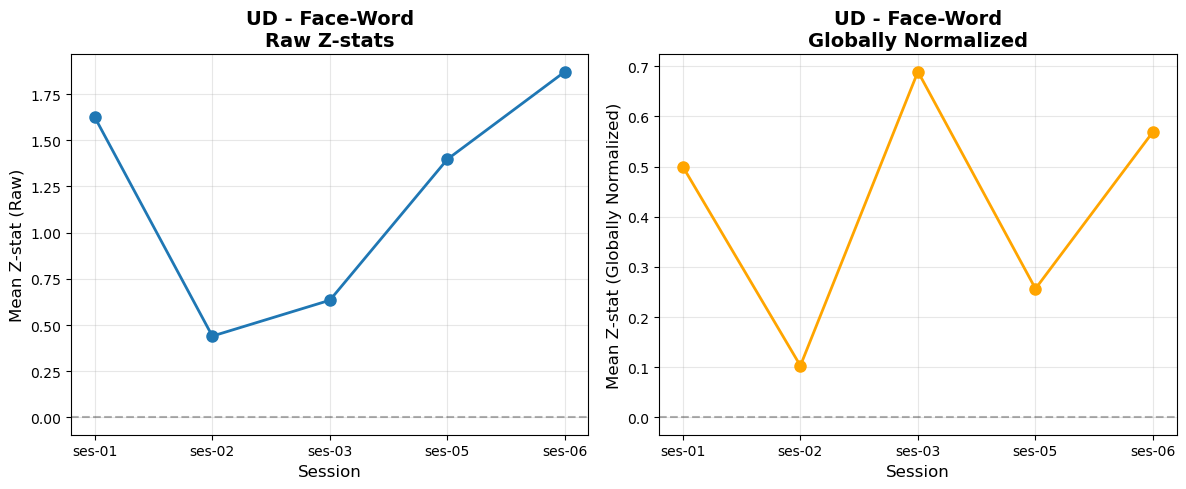


UD - Face-Word Trajectory Comparison:
Session        Raw Mean    Norm Mean   Difference
------------------------------------------------------------
ses-01             1.62         0.50        -1.12
ses-02             0.44         0.10        -0.34
ses-03             0.63         0.69         0.05
ses-05             1.40         0.26        -1.14
ses-06             1.87         0.57        -1.30




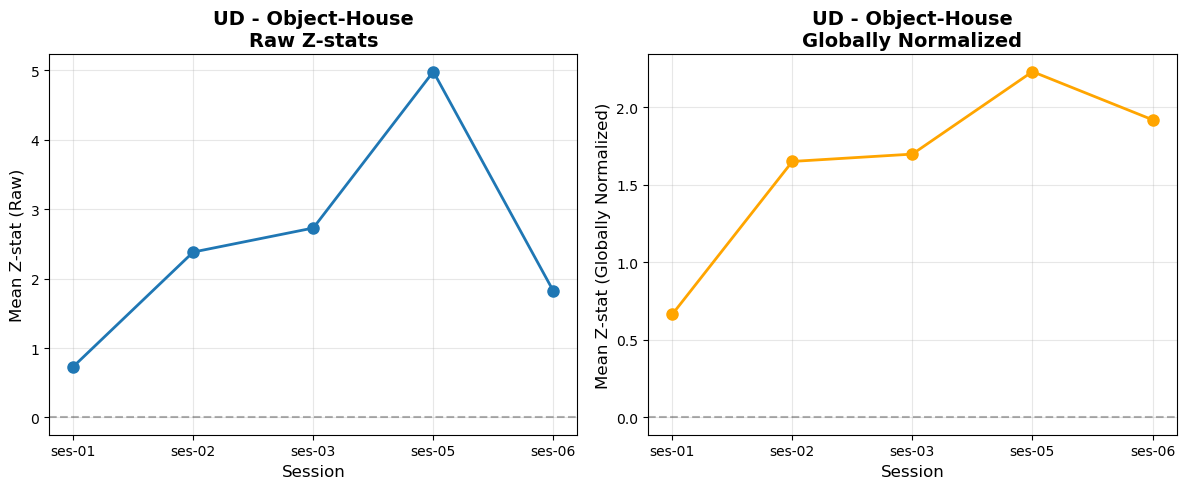


UD - Object-House Trajectory Comparison:
Session        Raw Mean    Norm Mean   Difference
------------------------------------------------------------
ses-01             0.73         0.67        -0.07
ses-02             2.38         1.65        -0.73
ses-03             2.73         1.70        -1.03
ses-05             4.98         2.23        -2.75
ses-06             1.82         1.92         0.10




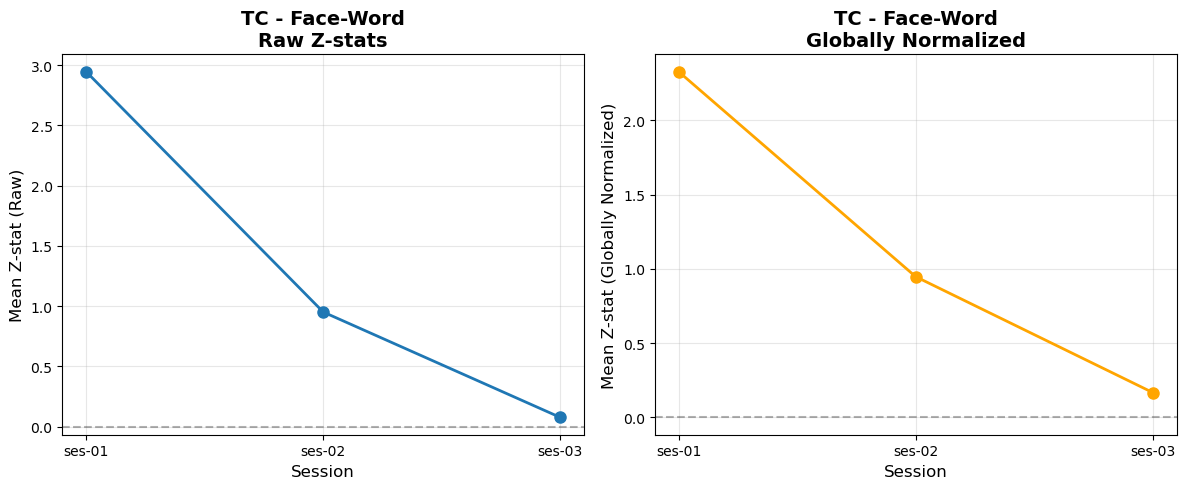


TC - Face-Word Trajectory Comparison:
Session        Raw Mean    Norm Mean   Difference
------------------------------------------------------------
ses-01             2.95         2.33        -0.62
ses-02             0.95         0.95        -0.00
ses-03             0.08         0.17         0.09




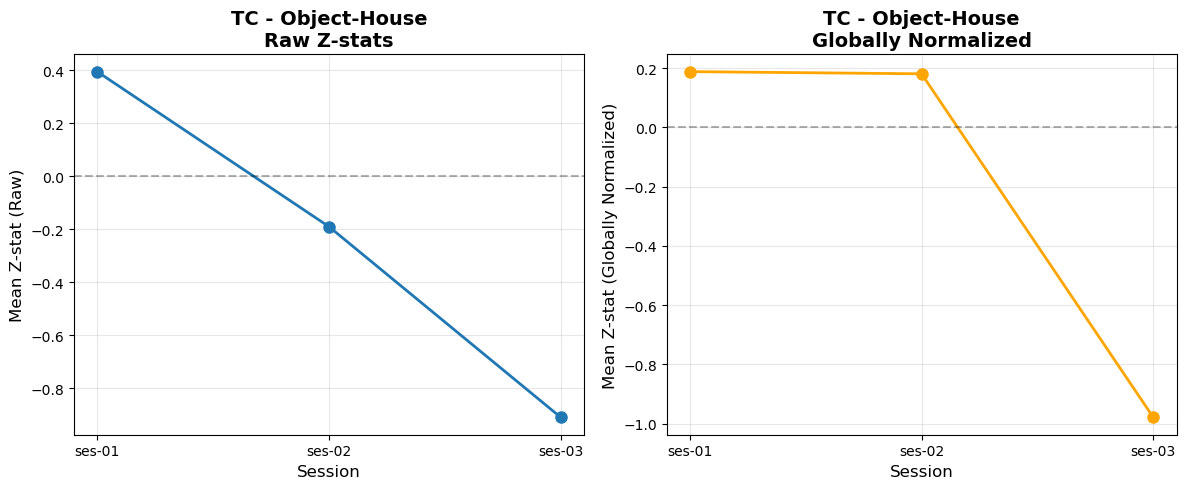


TC - Object-House Trajectory Comparison:
Session        Raw Mean    Norm Mean   Difference
------------------------------------------------------------
ses-01             0.39         0.19        -0.21
ses-02            -0.19         0.18         0.37
ses-03            -0.91        -0.98        -0.07




In [26]:
# NEW CELL 3: Visualize the effect of global normalization
def plot_normalization_effect(subject_id, roi_type='face_word'):
    """
    Plot raw vs normalized values to show effect of global normalization
    """
    code = SUBJECTS[subject_id]['code']
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    
    # Extract both versions
    raw_data, n_vox, _, raw_stats = extract_contrast_values_v2(
        subject_id, roi_type, use_anatomical_only=False, global_normalize=False)
    norm_data, _, _, norm_stats = extract_contrast_values_v2(
        subject_id, roi_type, use_anatomical_only=False, global_normalize=True)
    
    sessions = sorted(raw_data.keys())
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Raw means
    raw_means = [raw_data[s].mean() for s in sessions]
    axes[0].plot(range(len(sessions)), raw_means, 'o-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Session', fontsize=12)
    axes[0].set_ylabel('Mean Z-stat (Raw)', fontsize=12)
    axes[0].set_title(f'{code} - {roi_name}\nRaw Z-stats', fontsize=14, fontweight='bold')
    axes[0].set_xticks(range(len(sessions)))
    axes[0].set_xticklabels([f'ses-{s}' for s in sessions])
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    # Plot 2: Normalized means
    norm_means = [norm_data[s].mean() for s in sessions]
    axes[1].plot(range(len(sessions)), norm_means, 'o-', linewidth=2, markersize=8, color='orange')
    axes[1].set_xlabel('Session', fontsize=12)
    axes[1].set_ylabel('Mean Z-stat (Globally Normalized)', fontsize=12)
    axes[1].set_title(f'{code} - {roi_name}\nGlobally Normalized', fontsize=14, fontweight='bold')
    axes[1].set_xticks(range(len(sessions)))
    axes[1].set_xticklabels([f'ses-{s}' for s in sessions])
    axes[1].grid(True, alpha=0.3)
    axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print comparison
    print(f"\n{code} - {roi_name} Trajectory Comparison:")
    print("="*60)
    print(f"{'Session':<10} {'Raw Mean':>12} {'Norm Mean':>12} {'Difference':>12}")
    print("-"*60)
    for i, s in enumerate(sessions):
        diff = norm_means[i] - raw_means[i]
        print(f"ses-{s:<6} {raw_means[i]:>12.2f} {norm_means[i]:>12.2f} {diff:>12.2f}")

# Visualize all
for subject_id in ['sub-004', 'sub-021']:
    for roi_type in ['face_word', 'object_house']:
        plot_normalization_effect(subject_id, roi_type)
        print("\n")

In [27]:
# Check data quality metrics per session
def check_session_quality(subject_id):
    """Check tSNR and global signal across sessions"""
    
    print(f"\n{subject_id} Data Quality Check")
    print("="*60)
    
    for session in SUBJECTS[subject_id]['sessions']:
        if session == '01':
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / 'cope13.feat' / 'stats' / 'zstat1.nii.gz'
        else:
            zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                         'HighLevel.gfeat' / 'cope13.feat' / 'stats' / 'zstat1_ses01.nii.gz'
        
        if zstat_file.exists():
            data = nib.load(zstat_file).get_fdata()
            brain_mask = data != 0
            
            brain_mean = data[brain_mask].mean()
            brain_std = data[brain_mask].std()
            brain_median = np.median(data[brain_mask])
            
            print(f"ses-{session}:")
            print(f"  Global mean: {brain_mean:.3f}")
            print(f"  Global std:  {brain_std:.3f}")
            print(f"  Global median: {brain_median:.3f}")

for subject_id in ['sub-004', 'sub-021']:
    check_session_quality(subject_id)


sub-004 Data Quality Check
ses-01:
  Global mean: 1.006
  Global std:  1.237
  Global median: 1.076
ses-02:
  Global mean: 0.314
  Global std:  1.226
  Global median: 0.259
ses-03:
  Global mean: -0.082
  Global std:  1.040
  Global median: -0.091
ses-05:
  Global mean: 1.059
  Global std:  1.320
  Global median: 1.059
ses-06:
  Global mean: 1.166
  Global std:  1.238
  Global median: 1.095

sub-021 Data Quality Check
ses-01:
  Global mean: 0.173
  Global std:  1.191
  Global median: 0.134
ses-02:
  Global mean: 0.030
  Global std:  0.973
  Global median: 0.014
ses-03:
  Global mean: -0.124
  Global std:  1.197
  Global median: -0.070


# START HERE

In [1]:
# Full competition matrix: all conditions in all clusters
def extract_competition_matrix(subject_id, roi_type='face_word', global_normalize=False):
    """
    Extract full competition matrix:
    - Face>all in face cluster AND word cluster
    - Word>all in face cluster AND word cluster
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_results = roi_results_dual[subject_id][roi_type]
    
    cluster1_mask = roi_results['cluster1_mask']  # face or object
    cluster2_mask = roi_results['cluster2_mask']  # word or house
    
    if roi_type == 'face_word':
        cond1_cope, cond1_name = 6, 'face'
        cond2_cope, cond2_name = 9, 'word'
    else:
        cond1_cope, cond1_name = 8, 'object'  # FIXED: was cond2_name
        cond2_cope, cond2_name = 7, 'house'
    
    # Store: [condition][cluster][session] = mean
    results = {
        cond1_name: {'cluster1': {}, 'cluster2': {}},
        cond2_name: {'cluster1': {}, 'cluster2': {}}
    }
    
    for session in SUBJECTS[subject_id]['sessions']:
        # Extract both conditions
        for cope_num, cond_name in [(cond1_cope, cond1_name), (cond2_cope, cond2_name)]:
            if session == '01':
                zstat_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
            else:
                zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
            
            if zstat_file.exists():
                zstat_img = nib.load(zstat_file)
                zstat_data = zstat_img.get_fdata()
                
                if global_normalize:
                    brain_mask = zstat_data != 0
                    global_mean = zstat_data[brain_mask].mean()
                    global_std = zstat_data[brain_mask].std()
                    zstat_data = (zstat_data - global_mean) / global_std
                
                # Extract from both clusters
                results[cond_name]['cluster1'][session] = zstat_data[cluster1_mask].mean()
                results[cond_name]['cluster2'][session] = zstat_data[cluster2_mask].mean()
    
    return results, cond1_name, cond2_name

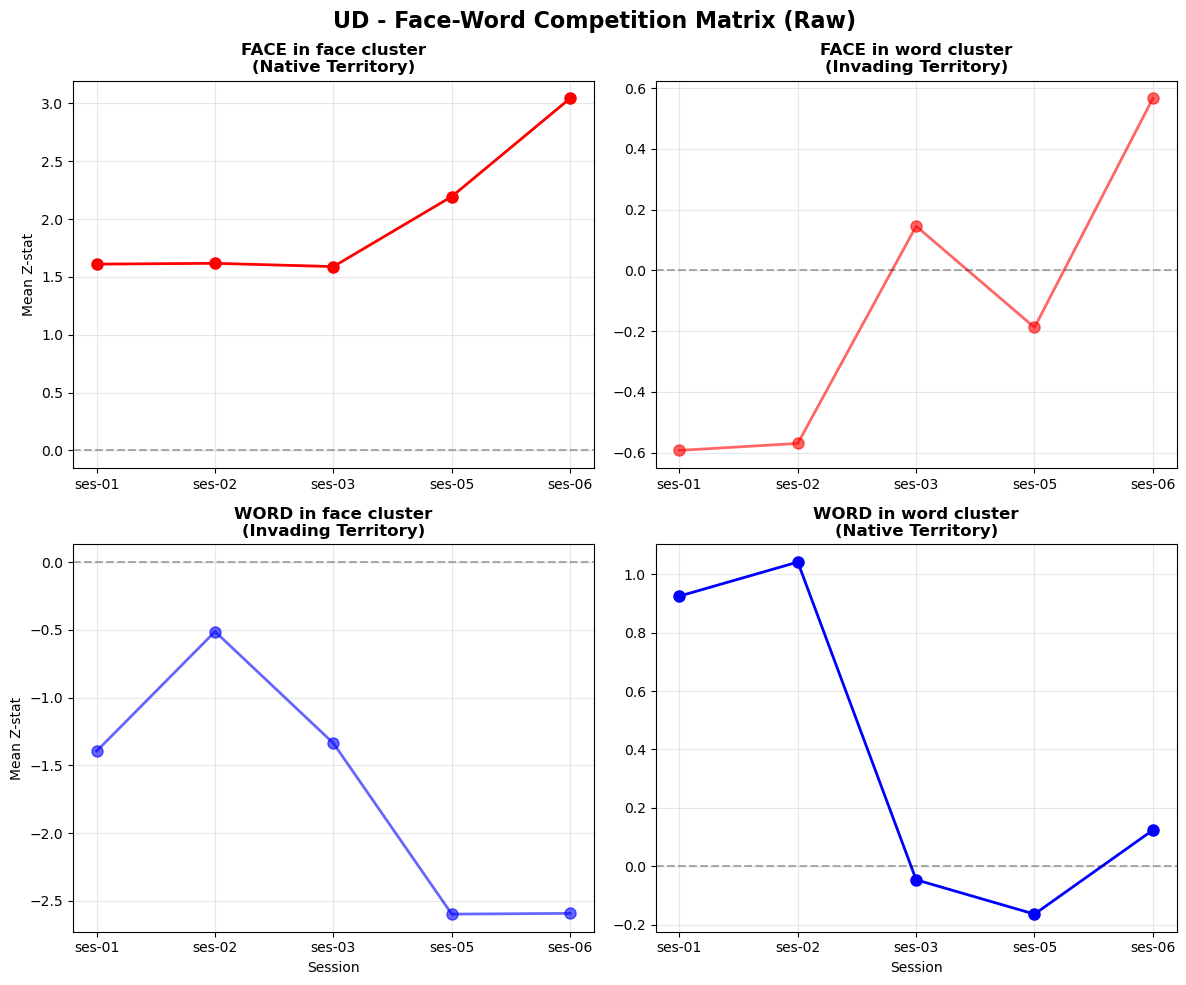


UD - Face-Word Competition Matrix (Raw)

ses-01:
  FACE in face cluster: 1.61
  FACE in word cluster: -0.59
  WORD in face cluster: -1.39
  WORD in word cluster: 0.93

ses-02:
  FACE in face cluster: 1.62
  FACE in word cluster: -0.57
  WORD in face cluster: -0.51
  WORD in word cluster: 1.04

ses-03:
  FACE in face cluster: 1.59
  FACE in word cluster: 0.15
  WORD in face cluster: -1.34
  WORD in word cluster: -0.05

ses-05:
  FACE in face cluster: 2.19
  FACE in word cluster: -0.19
  WORD in face cluster: -2.60
  WORD in word cluster: -0.16

ses-06:
  FACE in face cluster: 3.04
  FACE in word cluster: 0.57
  WORD in face cluster: -2.59
  WORD in word cluster: 0.12


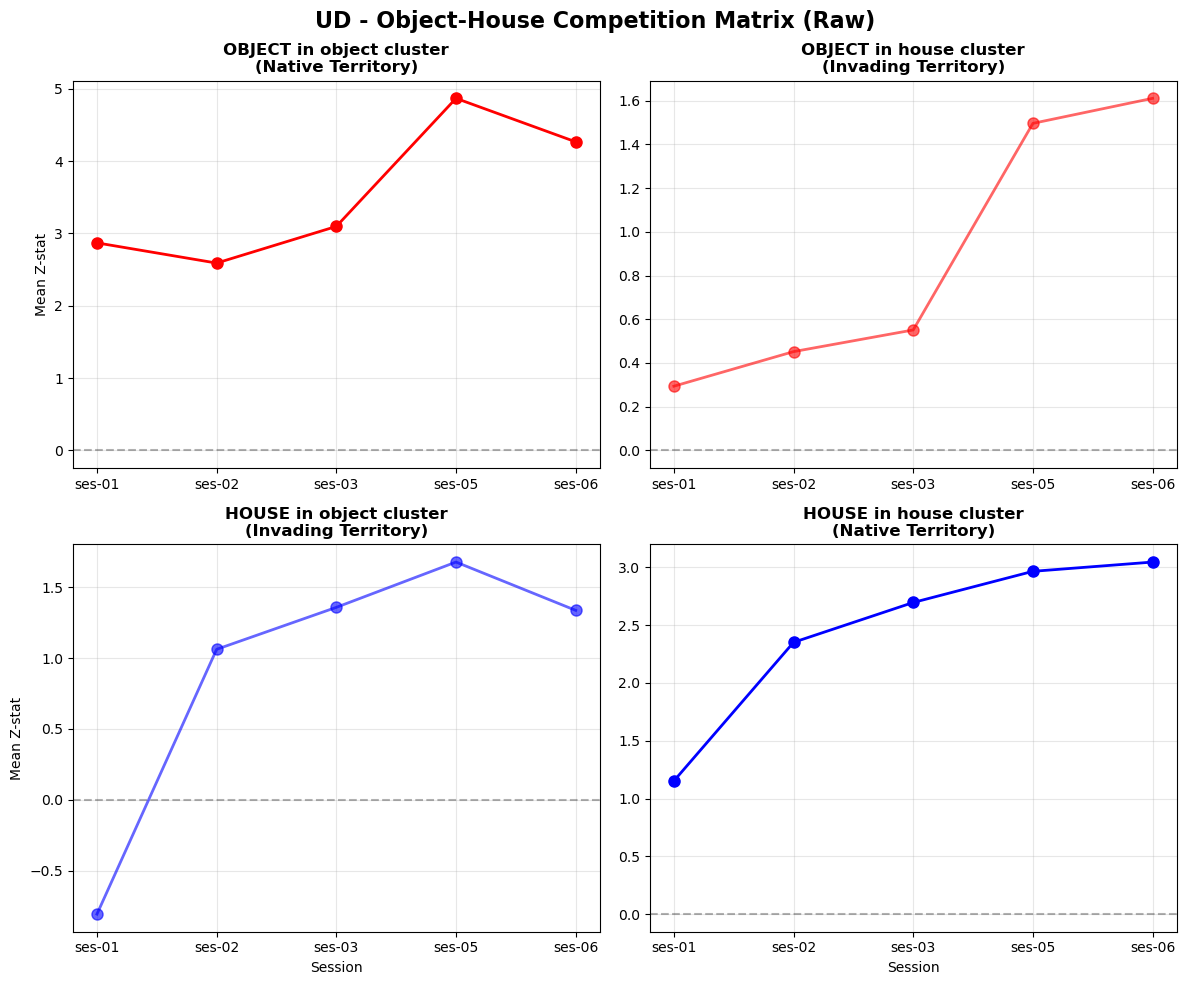


UD - Object-House Competition Matrix (Raw)

ses-01:
  OBJECT in object cluster: 2.87
  OBJECT in house cluster: 0.29
  HOUSE in object cluster: -0.81
  HOUSE in house cluster: 1.15

ses-02:
  OBJECT in object cluster: 2.59
  OBJECT in house cluster: 0.45
  HOUSE in object cluster: 1.06
  HOUSE in house cluster: 2.35

ses-03:
  OBJECT in object cluster: 3.10
  OBJECT in house cluster: 0.55
  HOUSE in object cluster: 1.36
  HOUSE in house cluster: 2.70

ses-05:
  OBJECT in object cluster: 4.87
  OBJECT in house cluster: 1.50
  HOUSE in object cluster: 1.68
  HOUSE in house cluster: 2.97

ses-06:
  OBJECT in object cluster: 4.26
  OBJECT in house cluster: 1.61
  HOUSE in object cluster: 1.34
  HOUSE in house cluster: 3.05


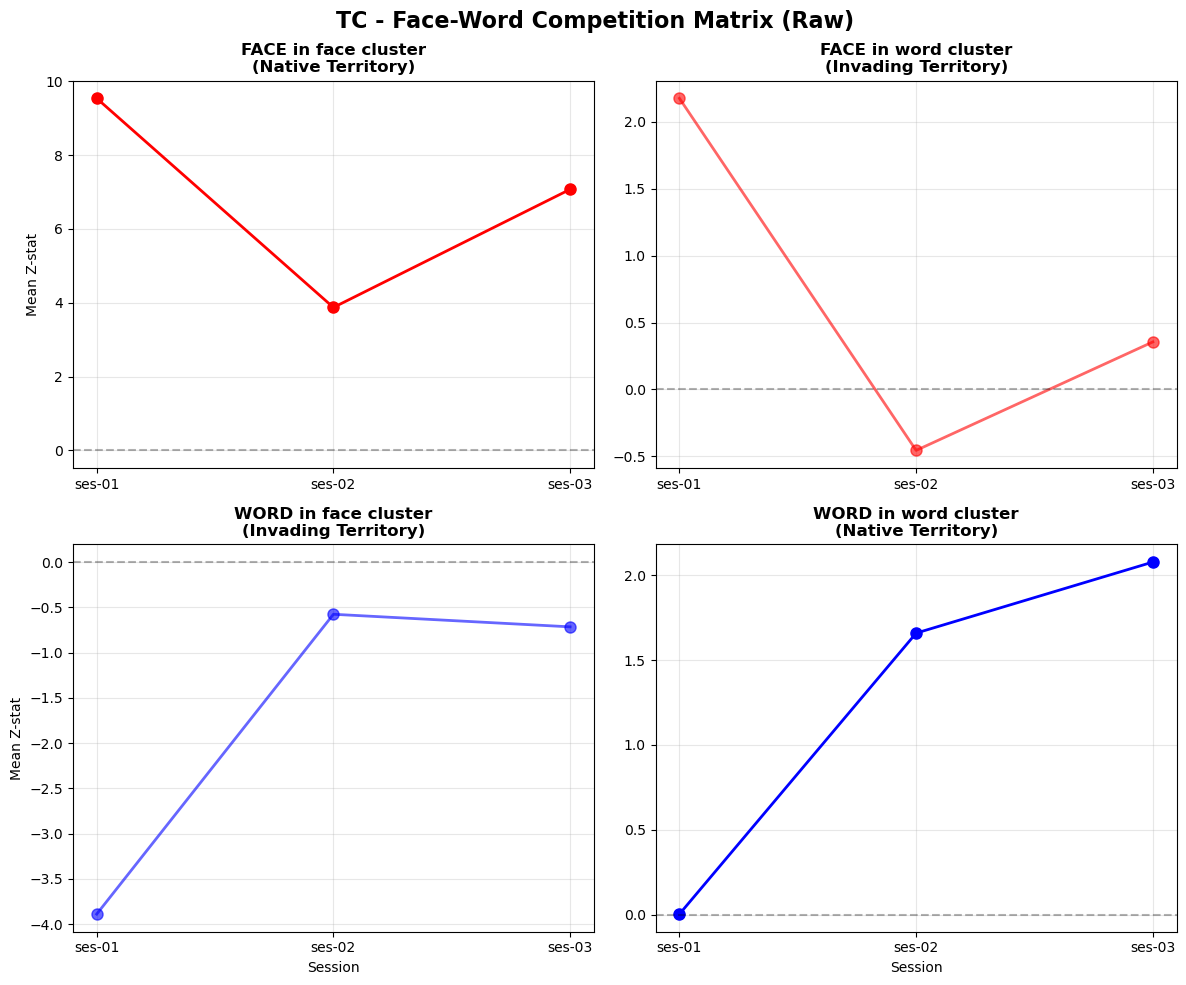


TC - Face-Word Competition Matrix (Raw)

ses-01:
  FACE in face cluster: 9.54
  FACE in word cluster: 2.18
  WORD in face cluster: -3.89
  WORD in word cluster: 0.00

ses-02:
  FACE in face cluster: 3.87
  FACE in word cluster: -0.46
  WORD in face cluster: -0.58
  WORD in word cluster: 1.66

ses-03:
  FACE in face cluster: 7.07
  FACE in word cluster: 0.36
  WORD in face cluster: -0.72
  WORD in word cluster: 2.08


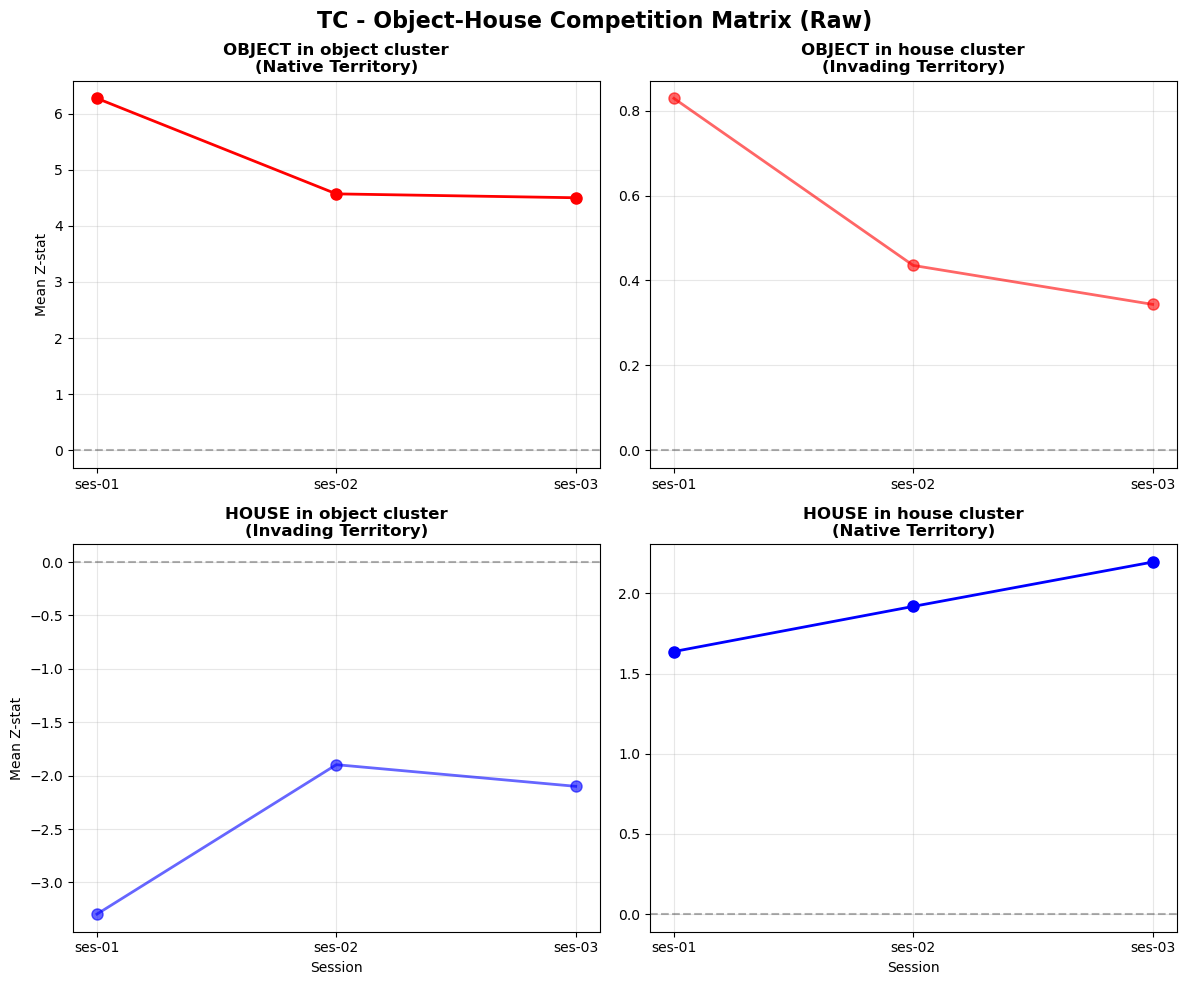


TC - Object-House Competition Matrix (Raw)

ses-01:
  OBJECT in object cluster: 6.27
  OBJECT in house cluster: 0.83
  HOUSE in object cluster: -3.30
  HOUSE in house cluster: 1.64

ses-02:
  OBJECT in object cluster: 4.57
  OBJECT in house cluster: 0.44
  HOUSE in object cluster: -1.90
  HOUSE in house cluster: 1.92

ses-03:
  OBJECT in object cluster: 4.50
  OBJECT in house cluster: 0.34
  HOUSE in object cluster: -2.10
  HOUSE in house cluster: 2.20


In [33]:
# Full competition matrix: all conditions in all clusters
def extract_competition_matrix(subject_id, roi_type='face_word', global_normalize=False):
    """
    Extract full competition matrix:
    - Face>all in face cluster AND word cluster
    - Word>all in face cluster AND word cluster
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_results = roi_results_dual[subject_id][roi_type]
    
    cluster1_mask = roi_results['cluster1_mask']  # face or object
    cluster2_mask = roi_results['cluster2_mask']  # word or house
    
    if roi_type == 'face_word':
        cond1_cope, cond1_name = 6, 'face'
        cond2_cope, cond2_name = 9, 'word'
    else:
        cond1_cope, cond1_name = 8, 'object'
        cond2_cope, cond2_name = 7, 'house'
    
    # Store: [condition][cluster][session] = mean
    results = {
        cond1_name: {'cluster1': {}, 'cluster2': {}},
        cond2_name: {'cluster1': {}, 'cluster2': {}}
    }
    
    for session in SUBJECTS[subject_id]['sessions']:
        # Extract both conditions
        for cope_num, cond_name in [(cond1_cope, cond1_name), (cond2_cope, cond2_name)]:
            if session == '01':
                zstat_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
            else:
                zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
            
            if zstat_file.exists():
                zstat_img = nib.load(zstat_file)
                zstat_data = zstat_img.get_fdata()
                
                if global_normalize:
                    brain_mask = zstat_data != 0
                    global_mean = zstat_data[brain_mask].mean()
                    global_std = zstat_data[brain_mask].std()
                    zstat_data = (zstat_data - global_mean) / global_std
                
                # Extract from both clusters
                results[cond_name]['cluster1'][session] = zstat_data[cluster1_mask].mean()
                results[cond_name]['cluster2'][session] = zstat_data[cluster2_mask].mean()
    
    return results, cond1_name, cond2_name

def plot_competition_matrix(subject_id, roi_type='face_word', global_normalize=False):
    """
    Plot 2x2 grid showing all condition×cluster combinations
    """
    code = SUBJECTS[subject_id]['code']
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    norm_label = "Normalized" if global_normalize else "Raw"
    
    results, cond1_name, cond2_name = extract_competition_matrix(
        subject_id, roi_type, global_normalize)
    
    sessions = SUBJECTS[subject_id]['sessions']
    session_nums = list(range(len(sessions)))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{code} - {roi_name} Competition Matrix ({norm_label})', 
                 fontsize=16, fontweight='bold')
    
    # Top left: Condition 1 in Cluster 1 (native territory)
    means = [results[cond1_name]['cluster1'][s] for s in sessions]
    axes[0, 0].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='red')
    axes[0, 0].set_title(f'{cond1_name.upper()} in {cond1_name} cluster\n(Native Territory)', 
                         fontweight='bold')
    axes[0, 0].set_ylabel('Mean Z-stat')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0, 0].set_xticks(session_nums)
    axes[0, 0].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Top right: Condition 1 in Cluster 2 (invading)
    means = [results[cond1_name]['cluster2'][s] for s in sessions]
    axes[0, 1].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='red', alpha=0.6)
    axes[0, 1].set_title(f'{cond1_name.upper()} in {cond2_name} cluster\n(Invading Territory)', 
                         fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0, 1].set_xticks(session_nums)
    axes[0, 1].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Bottom left: Condition 2 in Cluster 1 (invading)
    means = [results[cond2_name]['cluster1'][s] for s in sessions]
    axes[1, 0].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='blue', alpha=0.6)
    axes[1, 0].set_title(f'{cond2_name.upper()} in {cond1_name} cluster\n(Invading Territory)', 
                         fontweight='bold')
    axes[1, 0].set_xlabel('Session')
    axes[1, 0].set_ylabel('Mean Z-stat')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 0].set_xticks(session_nums)
    axes[1, 0].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Bottom right: Condition 2 in Cluster 2 (native territory)
    means = [results[cond2_name]['cluster2'][s] for s in sessions]
    axes[1, 1].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='blue')
    axes[1, 1].set_title(f'{cond2_name.upper()} in {cond2_name} cluster\n(Native Territory)', 
                         fontweight='bold')
    axes[1, 1].set_xlabel('Session')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].set_xticks(session_nums)
    axes[1, 1].set_xticklabels([f'ses-{s}' for s in sessions])
    
    plt.tight_layout()
    plt.show()
    
    # Print full matrix
    print(f"\n{code} - {roi_name} Competition Matrix ({norm_label})")
    print("="*80)
    for session in sessions:
        print(f"\nses-{session}:")
        print(f"  {cond1_name.upper()} in {cond1_name} cluster: {results[cond1_name]['cluster1'][session]:.2f}")
        print(f"  {cond1_name.upper()} in {cond2_name} cluster: {results[cond1_name]['cluster2'][session]:.2f}")
        print(f"  {cond2_name.upper()} in {cond1_name} cluster: {results[cond2_name]['cluster1'][session]:.2f}")
        print(f"  {cond2_name.upper()} in {cond2_name} cluster: {results[cond2_name]['cluster2'][session]:.2f}")

# Run for both subjects and ROI types
for subject_id in ['sub-004', 'sub-021']:
    plot_competition_matrix(subject_id, 'face_word', global_normalize=False)
    plot_competition_matrix(subject_id, 'object_house', global_normalize=False)

In [2]:
# Full competition matrix: all conditions in all clusters
def extract_competition_matrix(subject_id, roi_type='face_word', global_normalize=False):
    """
    Extract full competition matrix:
    - Face>all in face cluster AND word cluster
    - Word>all in face cluster AND word cluster
    """
    
    hemi = SUBJECTS[subject_id]['hemi']
    roi_results = roi_results_dual[subject_id][roi_type]
    
    cluster1_mask = roi_results['cluster1_mask']  # face or object
    cluster2_mask = roi_results['cluster2_mask']  # word or house
    
    if roi_type == 'face_word':
        cond1_cope, cond1_name = 6, 'face'
        cond2_cope, cond2_name = 9, 'word'
    else:
        cond1_cope, cond1_name = 8, 'object'
        cond2_cope, cond2_name = 7, 'house'
    
    # Store: [condition][cluster][session] = mean
    results = {
        cond1_name: {'cluster1': {}, 'cluster2': {}},
        cond2_name: {'cluster1': {}, 'cluster2': {}}
    }
    
    for session in SUBJECTS[subject_id]['sessions']:
        # Extract both conditions
        for cope_num, cond_name in [(cond1_cope, cond1_name), (cond2_cope, cond2_name)]:
            if session == '01':
                zstat_file = BASE_DIR / subject_id / 'ses-01' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1.nii.gz'
            else:
                zstat_file = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / \
                            'HighLevel.gfeat' / f'cope{cope_num}.feat' / 'stats' / 'zstat1_ses01.nii.gz'
            
            if zstat_file.exists():
                zstat_img = nib.load(zstat_file)
                zstat_data = zstat_img.get_fdata()
                
                if global_normalize:
                    brain_mask = zstat_data != 0
                    global_mean = zstat_data[brain_mask].mean()
                    global_std = zstat_data[brain_mask].std()
                    zstat_data = (zstat_data - global_mean) / global_std
                
                # Extract from both clusters
                results[cond_name]['cluster1'][session] = zstat_data[cluster1_mask].mean()
                results[cond_name]['cluster2'][session] = zstat_data[cluster2_mask].mean()
    
    return results, cond1_name, cond2_name

def plot_competition_matrix(subject_id, roi_type='face_word', global_normalize=False):
    """
    Plot 2x2 grid showing all condition×cluster combinations
    """
    code = SUBJECTS[subject_id]['code']
    roi_name = 'Face-Word' if roi_type == 'face_word' else 'Object-House'
    norm_label = "Normalized" if global_normalize else "Raw"
    
    results, cond1_name, cond2_name = extract_competition_matrix(
        subject_id, roi_type, global_normalize)
    
    sessions = SUBJECTS[subject_id]['sessions']
    session_nums = list(range(len(sessions)))
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{code} - {roi_name} Competition Matrix ({norm_label})', 
                 fontsize=16, fontweight='bold')
    
    # Top left: Condition 1 in Cluster 1 (native territory)
    means = [results[cond1_name]['cluster1'][s] for s in sessions]
    axes[0, 0].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='red')
    axes[0, 0].set_title(f'{cond1_name.upper()} in {cond1_name} cluster\n(Native Territory)', 
                         fontweight='bold')
    axes[0, 0].set_ylabel('Mean Z-stat')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0, 0].set_xticks(session_nums)
    axes[0, 0].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Top right: Condition 1 in Cluster 2 (invading)
    means = [results[cond1_name]['cluster2'][s] for s in sessions]
    axes[0, 1].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='red', alpha=0.6)
    axes[0, 1].set_title(f'{cond1_name.upper()} in {cond2_name} cluster\n(Invading Territory)', 
                         fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[0, 1].set_xticks(session_nums)
    axes[0, 1].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Bottom left: Condition 2 in Cluster 1 (invading)
    means = [results[cond2_name]['cluster1'][s] for s in sessions]
    axes[1, 0].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='blue', alpha=0.6)
    axes[1, 0].set_title(f'{cond2_name.upper()} in {cond1_name} cluster\n(Invading Territory)', 
                         fontweight='bold')
    axes[1, 0].set_xlabel('Session')
    axes[1, 0].set_ylabel('Mean Z-stat')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 0].set_xticks(session_nums)
    axes[1, 0].set_xticklabels([f'ses-{s}' for s in sessions])
    
    # Bottom right: Condition 2 in Cluster 2 (native territory)
    means = [results[cond2_name]['cluster2'][s] for s in sessions]
    axes[1, 1].plot(session_nums, means, 'o-', linewidth=2, markersize=8, color='blue')
    axes[1, 1].set_title(f'{cond2_name.upper()} in {cond2_name} cluster\n(Native Territory)', 
                         fontweight='bold')
    axes[1, 1].set_xlabel('Session')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
    axes[1, 1].set_xticks(session_nums)
    axes[1, 1].set_xticklabels([f'ses-{s}' for s in sessions])
    
    plt.tight_layout()
    plt.show()
    
    # Print full matrix
    print(f"\n{code} - {roi_name} Competition Matrix ({norm_label})")
    print("="*80)
    for session in sessions:
        print(f"\nses-{session}:")
        print(f"  {cond1_name.upper()} in {cond1_name} cluster: {results[cond1_name]['cluster1'][session]:.2f}")
        print(f"  {cond1_name.upper()} in {cond2_name} cluster: {results[cond1_name]['cluster2'][session]:.2f}")
        print(f"  {cond2_name.upper()} in {cond1_name} cluster: {results[cond2_name]['cluster1'][session]:.2f}")
        print(f"  {cond2_name.upper()} in {cond2_name} cluster: {results[cond2_name]['cluster2'][session]:.2f}")

# Run for both subjects and ROI types
for subject_id in ['sub-004', 'sub-021']:
    plot_competition_matrix(subject_id, 'face_word', global_normalize=False)
    plot_competition_matrix(subject_id, 'object_house', global_normalize=False)

NameError: name 'SUBJECTS' is not defined